In [9]:
from osgeo import gdal
from osgeo import ogr 
dem_data=ogr.Open(r"C:\Users\shubh\Documents\Analytics\Haul Roads WS\HaulRoads Data Files\HaulRoads_DEM.tif")
gt=dem_data.GetGeoTransform()
bands=dem_data.RasterCount
bands
gt

AttributeError: 'NoneType' object has no attribute 'GetGeoTransform'

In [10]:
from shapely.wkb import loads
# création d'une couche ogr LineString pour regrouper tous les segments
# éventuels d'une couche ligne
profilogr = ogr.Geometry(ogr.wkbLineString)
# ouverture du fichier shapefile et intégration des segments éventuels
source = ogr.Open(r"C:\Users\shubh\Documents\Analytics\Haul Roads WS\HaulRoads Data Files\HaulRoads_SHP.shp")
cshp = source.GetLayer()
for element in cshp:
      geom =element.GetGeometryRef()
      profilogr = profilogr.Union(geom)
# transformation en géométrie Shapely
profilshp = loads(profilogr.ExportToWkb())
# création des points équidistants sur la ligne avec un pas de 20m
longueur=profilshp.length
x = []
y = []
z = []
# couleur RGB
couleur = []
# distance pour le profil topographique
dista = []
for distance in range(0,longueur,20):
         # création du point sur la ligne 
         point = profilshp.interpolate(distance)
         xp,yp=point.x, point.y
         x.append(xp)
         y.append(yp)
         # extraction de la valeur altitude à partir du MNT
         z.append(Val_raster(paramètres de la couche MNT)[0])
         # extraction des couleurs RGB à partir de la couche raster
         couleur.append(Val_raster(paramètres de la couche raster))
         dista.append(distance)

SyntaxError: invalid syntax (1822657843.py, line 29)

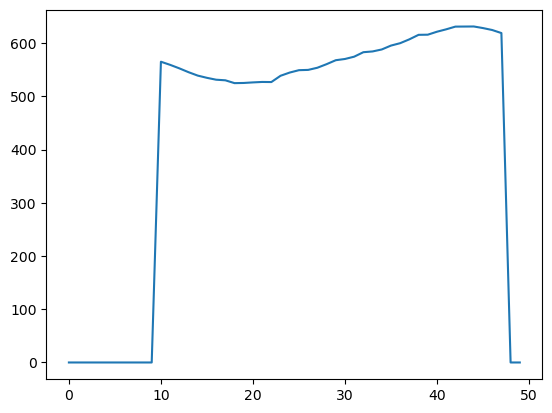

In [2]:
import rioxarray
import shapely.geometry
import matplotlib.pyplot as plt

sample_tif = (r"C:\Users\shubh\Documents\Analytics\Haul Roads WS\HaulRoads Data Files\HaulRoads_DEM.tif")

# Load xarray
tile = rioxarray.open_rasterio(sample_tif).squeeze()
# create a line (here its the diagonal of tile)
line = shapely.geometry.MultiLineString([[
            [tile.x[-1],tile.y[-1]],
            [tile.x[0], tile.y[0]]]])

def extract_along_line(xarr, line, n_samples=50):
    profile = []

    for i in range(n_samples):
        # get next point on the line
        point = line.interpolate(i / n_samples - 1., normalized=True)
        # access the nearest pixel in the xarray
        value = xarr.sel(x=point.x, y=point.y, method="nearest").data
        profile.append(value)
        
    return profile

# use the method from above to extract the profile
profile = extract_along_line(tile, line)
plt.plot(profile)
plt.show()

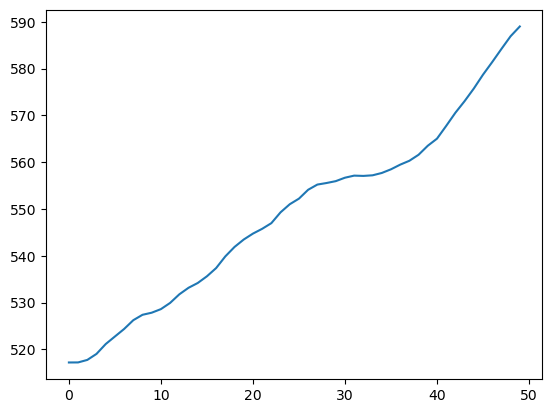

In [3]:
import rioxarray
import shapely.geometry
import matplotlib.pyplot as plt
import geopandas as gpd

sample_tif = r"C:\Users\shubh\Documents\Analytics\Haul Roads WS\HaulRoads Data Files\HaulRoads_DEM.tif"
line_shapefile = r"C:\Users\shubh\Documents\Analytics\Haul Roads WS\HaulRoads Data Files\HRCL_Final_SHP.shp"

# Load xarray
tile = rioxarray.open_rasterio(sample_tif).squeeze()

# Load the shapefile
gdf = gpd.read_file(line_shapefile)

# Ensure the shapefile contains only lines and extract the first line
line = gdf.geometry.iloc[0]

def extract_along_line(xarr, line, n_samples=50):
    profile = []

    for i in range(n_samples):
        # get next point on the line
        point = line.interpolate(i / n_samples - 1., normalized=True)
        # access the nearest pixel in the xarray
        value = xarr.sel(x=point.x, y=point.y, method="nearest").data
        profile.append(value)
        
    return profile

# Use the method from above to extract the profile
profile = extract_along_line(tile, line)
plt.plot(profile)
plt.show()


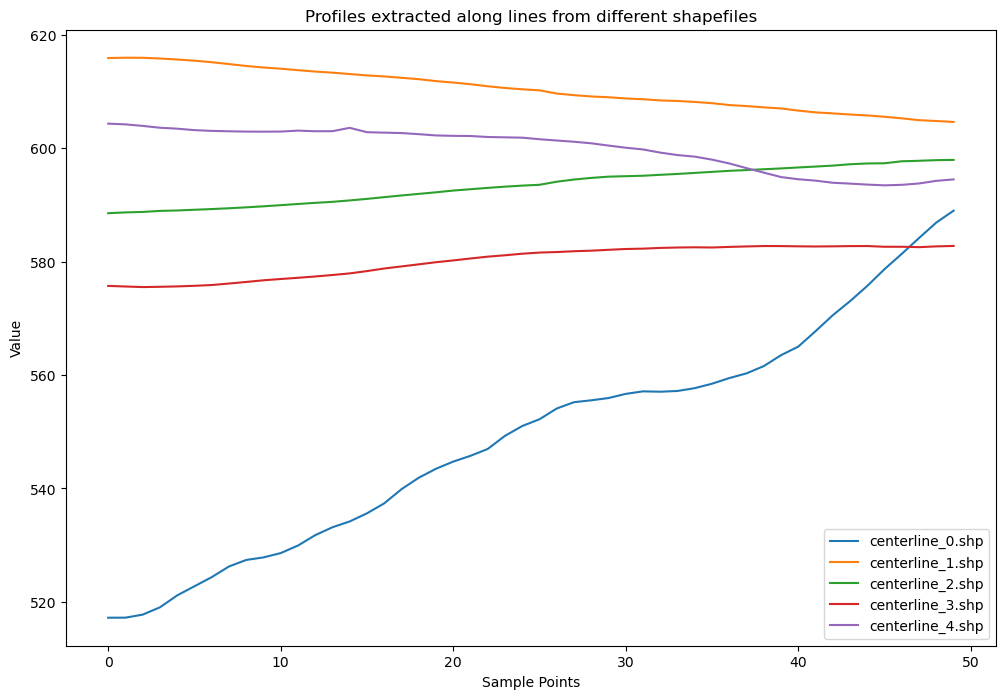

In [4]:
import os
import rioxarray
import shapely.geometry
import matplotlib.pyplot as plt
import geopandas as gpd

sample_tif = r"C:\Users\shubh\Documents\Analytics\Haul Roads WS\HaulRoads Data Files\HaulRoads_DEM.tif"
shapefiles_dir = r"C:\Users\shubh\Documents\Analytics\Haul Roads WS\HaulRoads Data Files\Centerlines"

# Load xarray
tile = rioxarray.open_rasterio(sample_tif).squeeze()

def extract_along_line(xarr, line, n_samples=50):
    profile = []

    for i in range(n_samples):
        # get next point on the line
        point = line.interpolate(i / n_samples - 1., normalized=True)
        # access the nearest pixel in the xarray
        value = xarr.sel(x=point.x, y=point.y, method="nearest").data
        profile.append(value)
        
    return profile

# Iterate over all shapefiles in the directory
profiles = []
for filename in os.listdir(shapefiles_dir):
    if filename.endswith(".shp"):
        shapefile_path = os.path.join(shapefiles_dir, filename)
        
        # Load the shapefile
        gdf = gpd.read_file(shapefile_path)
        
        # Iterate over all lines in the shapefile
        for line in gdf.geometry:
            if isinstance(line, shapely.geometry.LineString):
                profile = extract_along_line(tile, line)
                profiles.append((filename, profile))

# Plot all profiles
plt.figure(figsize=(12, 8))
for filename, profile in profiles:
    plt.plot(profile, label=filename)
plt.legend()
plt.xlabel("Sample Points")
plt.ylabel("Value")
plt.title("Profiles extracted along lines from different shapefiles")
plt.show()
